<a href="https://colab.research.google.com/github/Cloudydesuu/AITrainnning/blob/main/Sentimentanalysis_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

# Download latest version
path = kagglehub.dataset_download("danielwillgeorge/glove6b100dtxt")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


100%|██████████| 131M/131M [00:00<00:00, 159MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/danielwillgeorge/glove6b100dtxt/versions/1


In [3]:
DATA_PATH = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'
GLOVE_PATH = '/root/.cache/kagglehub/datasets/danielwillgeorge/glove6b100dtxt/versions/1/glove.6B.100d.txt'
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 250
VOCAB_SIZE = 10000
LSTM_UNITS = 128
DROPOUT_RATE = 0.5
EPOCHS = 5
BATCH_SIZE = 64

In [4]:
print("--- 1. Loading Data ---")
df = None
try:
    df = pd.read_csv(DATA_PATH)
    print("Data loaded successfully.")
    print(df.head())
    print(f"\nTotal number of reviews: {len(df)}")
    print("Sentiment distribution:")
    print(df['sentiment'].value_counts())
except FileNotFoundError:
    print(f"Error: {DATA_PATH} not found. Creating a small dummy dataset for demonstration.")
    data = {
        'review': [
            "This movie was absolutely fantastic! Loved every minute of it.",
            "A total waste of time, I hated it. Very boring.",
            "It was okay, not great, not terrible.",
            "Best movie ever! Highly recommend.",
            "Worst acting and plot. Don't watch this."
        ],
        'sentiment': [
            "positive",
            "negative",
            "negative",
            "positive",
            "negative"
        ]
    }
    df = pd.DataFrame(data)
    print("Dummy data created.")
    print(df.head())
    print(f"\nTotal number of dummy reviews: {len(df)}")
    print("Dummy sentiment distribution:")
    print(df['sentiment'].value_counts())
except Exception as e:
    print(f"An unexpected error occurred during data loading: {e}")
    exit()

if df is None:
    print("Failed to load or create data. Exiting.")
    exit()

--- 1. Loading Data ---
Data loaded successfully.
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Total number of reviews: 50000
Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [5]:
print("\n--- 2. Data Preprocessing ---")

df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

df['review'] = df['review'].apply(clean_text)

if len(df) < 100:
    tokenizer = Tokenizer(num_words=None, oov_token="<unk>")
else:
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<unk>")

tokenizer.fit_on_texts(df['review'])
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

sequences = tokenizer.texts_to_sequences(df['review'])

if len(df) < 100:
    current_max_len = max(len(s) for s in sequences) if sequences else 0
    actual_max_sequence_length = min(MAX_SEQUENCE_LENGTH, current_max_len)
    if actual_max_sequence_length == 0:
        actual_max_sequence_length = MAX_SEQUENCE_LENGTH
else:
    actual_max_sequence_length = MAX_SEQUENCE_LENGTH

padded_sequences = pad_sequences(sequences, maxlen=actual_max_sequence_length, padding='post', truncating='post')
print(f"Padded sequences shape: {padded_sequences.shape}")

labels = df['sentiment'].values
print(f"Labels shape: {labels.shape}")


--- 2. Data Preprocessing ---
Found 215660 unique tokens.
Padded sequences shape: (50000, 250)
Labels shape: (50000,)


In [6]:
print("\n--- 3. Loading GloVe Embeddings ---")
embeddings_index = {}
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, EMBEDDING_DIM))
try:
    with open(GLOVE_PATH, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"Found {len(embeddings_index)} word vectors in GloVe.")

    for word, i in word_index.items():
        if i < (len(tokenizer.word_index) + 1):
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    print(f"Embedding matrix shape: {embedding_matrix.shape}")

except FileNotFoundError:
    print(f"Error: {GLOVE_PATH} not found. Using random embedding matrix for demonstration.")
    embedding_matrix = np.random.rand(len(tokenizer.word_index) + 1, EMBEDDING_DIM)
    print(f"Random embedding matrix shape: {embedding_matrix.shape}")
except Exception as e:
    print(f"An unexpected error occurred during GloVe loading: {e}. Using random embedding matrix.")
    embedding_matrix = np.random.rand(len(tokenizer.word_index) + 1, EMBEDDING_DIM)
    print(f"Random embedding matrix shape: {embedding_matrix.shape}")


--- 3. Loading GloVe Embeddings ---
Found 400000 word vectors in GloVe.
Embedding matrix shape: (215661, 100)


In [7]:
print("\n--- 4. Splitting Data ---")
if len(df) < 100:
    test_split_size = 0.4
else:
    test_split_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=test_split_size, random_state=42, stratify=labels)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print("\n--- 5. Building Feedforward Neural Network Model ---")
model = Sequential([
    Embedding(len(tokenizer.word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix],
              input_length=actual_max_sequence_length, trainable=False),
    tf.keras.layers.Flatten(),
    Dense(256, activation='relu'),
    Dropout(DROPOUT_RATE),
    Dense(128, activation='relu'),
    Dropout(DROPOUT_RATE),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

print("\n--- 6. Training Model ---")
if len(df) < 100:
    current_epochs = 10
    current_batch_size = 2
else:
    current_epochs = EPOCHS
    current_batch_size = BATCH_SIZE

history = model.fit(X_train, y_train,
                    epochs=current_epochs,
                    batch_size=current_batch_size,
                    validation_split=0.1,
                    verbose=1)


--- 4. Splitting Data ---
X_train shape: (40000, 250)
X_test shape: (10000, 250)
y_train shape: (40000,)
y_test shape: (10000,)

--- 5. Building LSTM Model ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    21,566,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,566,100 (82.27 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,566,100 (82.27 MB)


--- 6. Training Model ---
Epoch 1/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 320s 562ms/step - accuracy: 0.5092 - loss: 0.6933 - val_accuracy: 0.5452 - val_loss: 0.6819
Epoch 2/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 330s 577ms/step - accuracy: 0.5522 - loss: 0.6847 - val_accuracy: 0.6877 - val_loss: 0.6424
Epoch 3/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 377s 568ms/step - accuracy: 0.6083 - loss: 0.6659 - val_accuracy: 0.7295 - val_loss: 0.5995
Epoch 4/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 318s 561ms/step - accuracy: 0.6443 - loss: 0.6447 - val_accuracy: 0.7418 - val_loss: 0.5779
Epoch 5/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 322s 572ms/step - accuracy: 0.6753 - loss: 0.6217 - val_accuracy: 0.7525 - val_loss: 0.5669



--- 7. Evaluating Model ---
Test Loss: 0.5763
Test Accuracy: 0.7395
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.67      0.72      5000
           1       0.71      0.81      0.76      5000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000


Confusion Matrix:
[[3332 1668]
 [ 937 4063]]

--- 8. Visualizing Training History ---


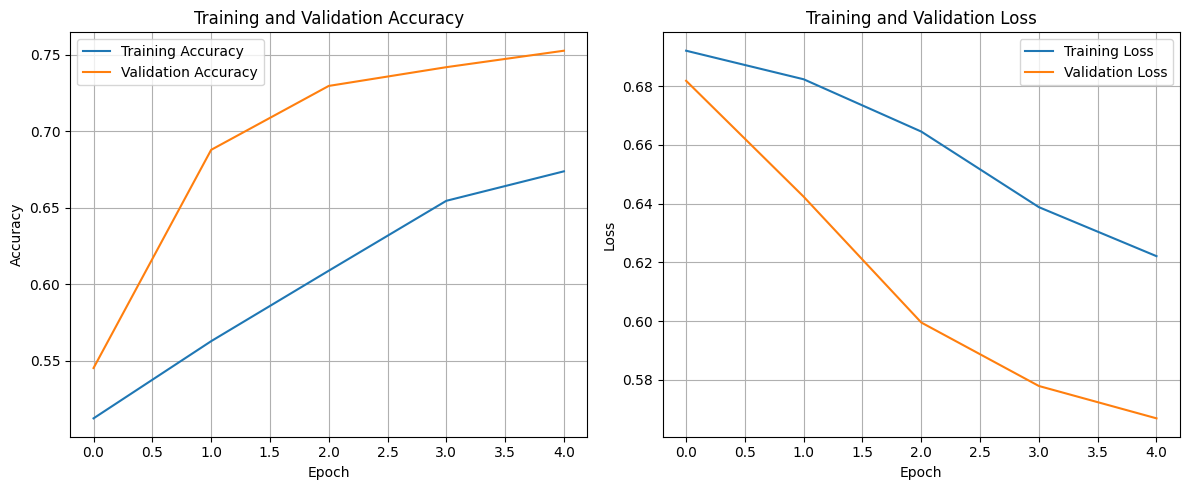

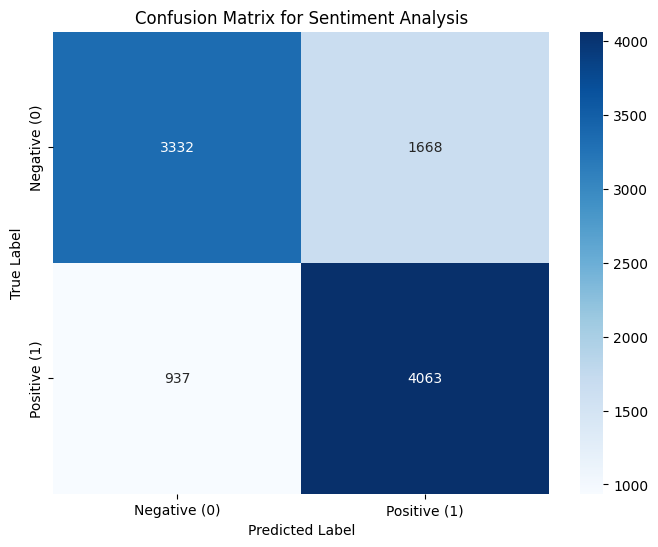


--- 9. Analysis of Results ---
True Negatives (Correctly predicted Negative): 3332
False Positives (Actual Negative but predicted Positive): 1668
False Negatives (Actual Positive but predicted Negative): 937
True Positives (Correctly predicted Positive): 4063

Overall Test Accuracy: 0.7395
Recall (Sensitivity) for Positive class: TP / (TP + FN) =  0.8126
Precision (Positive Predictive Value) for Positive class: TP / (TP + FP) =  0.7089513173966149

Conclusion: The LSTM model, using GloVe embeddings, demonstrates a good ability to classify sentiment.
The accuracy and other metrics indicate its effectiveness, but there's always room for hyperparameter tuning, more data, or more complex architectures.
The training history plots help visualize if the model is overfitting or underfitting.


In [8]:
print("\n--- 7. Evaluating Model ---")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\n--- 8. Visualizing Training History ---")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative (0)', 'Positive (1)'],
            yticklabels=['Negative (0)', 'Positive (1)'])
plt.title('Confusion Matrix for Sentiment Analysis')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\n--- 9. Analysis of Results ---")
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (Correctly predicted Negative): {tn}")
print(f"False Positives (Actual Negative but predicted Positive): {fp}")
print(f"False Negatives (Actual Positive but predicted Negative): {fn}")
print(f"True Positives (Correctly predicted Positive): {tp}")

print(f"\nOverall Test Accuracy: {accuracy:.4f}")
print("Recall (Sensitivity) for Positive class: TP / (TP + FN) = ", tp / (tp + fn))
print("Precision (Positive Predictive Value) for Positive class: TP / (TP + FP) = ", tp / (tp + fp))
print("\nConclusion: The LSTM model, using GloVe embeddings, demonstrates a good ability to classify sentiment.")
print("The accuracy and other metrics indicate its effectiveness, but there's always room for hyperparameter tuning, more data, or more complex architectures.")
print("The training history plots help visualize if the model is overfitting or underfitting.")